In [1]:
import io
import os
import torch
import urllib
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from collections import defaultdict
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from matplotlib import pyplot as plt
from ml_things import plot_dict, plot_confusion_matrix, fix_text
from sklearn.metrics import classification_report, accuracy_score
from transformers import (AutoConfig, AutoModelForSequenceClassification, AutoTokenizer, AdamW, get_linear_schedule_with_warmup,set_seed,)

/Users/pranavdeepak/miniforge3/lib/python3.10/site-packages/huggingface_hub/inference/_text_generation.py:121: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.5/migration/
  @validator("best_of")
/Users/pranavdeepak/miniforge3/lib/python3.10/site-packages/huggingface_hub/inference/_text_generation.py:140: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.5/migration/
  @validator("repetition_penalty")
/Users/pranavdeepak/miniforge3/lib/python3.10/site-packages/huggi

In [2]:

set_seed(123)

epochs = 2
batch_size = 16
max_length = 312
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name_or_path = "cardiffnlp/twitter-xlm-roberta-base"

labels_ids = {'india': 0, 'pakistan': 1, 'news': 2, 'international': 3, 'entertainment': 4, 'sport': 5, 'science': 6, 'china': 7, 'learningenglish': 8, 'social': 9, 'southasia': 10, 'business': 11, 'institutional': 12, 'multimedia': 13}

n_labels = len(labels_ids)

/Users/pranavdeepak/miniforge3/lib/python3.10/site-packages/flatbuffers/compat.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


In [3]:
import pandas as pd 

df = pd.read_csv("./dataset/preprocessed_text.csv", encoding='utf-8',sep=',')
df.head()

,text,label
0,मेट्रो लाइन चलने दक्षिणी दिल्ली नोएडा काफी जाए...,india
1,नेटिजन यानि इंटरनेट सक्रिय नागरिक ट्विटर सरकार...,pakistan
2,फ़्लाइट एटेनडेंट मदद गुहार डिक चेनी निर्देश ज़...,news
3,प्रतीक खुलेपन आज़ाद ख्याली भीड़ अलग का.सवा साल...,india
4,ख़ासकर पिछले साल प्रधानमंत्री मनमोहन सिंह सुनन...,india


In [4]:
df.tail()

,text,label
3462,उन्हें पता चलता व्यक्ति परेशानी खड़ी जिसके हाथ...,india
3463,सदन कार्यवाही शुरू तमिलनाडु वीसीके पार्टी तिरु...,india
3464,चीन पिछले हफ़्ते अप्रत्यक्ष रूप भारत चेतावनी द...,news
3465,मुक्ता आर्ट्स कांची कहानी ख़ूबसूरत लड़की कांची...,entertainment
3466,फॉक्स स्टार स्टूडियोज़ विशेष फ़िल्म्स सिटीलाइट...,entertainment


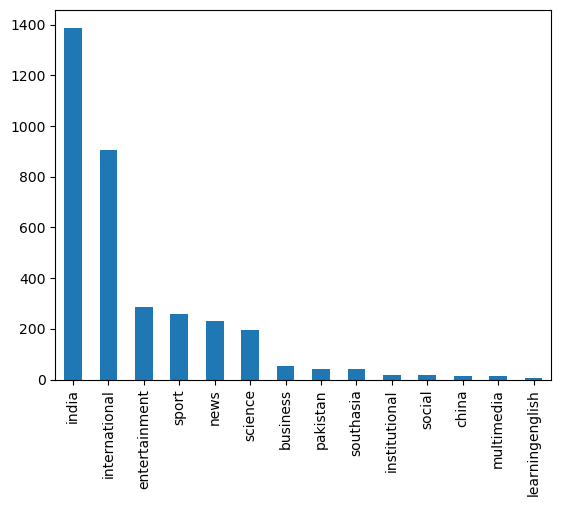

In [6]:
df['label'].value_counts()

df['label'].value_counts().plot(kind='bar')

In [8]:
import numpy as np
train, val, test = np.split(df.sample(frac=1), [int(.75*len(df)), int(.82*len(df))])

In [9]:
print ("Size of training dataset-->", len(train))
print ("Size of test dataset-->", len(test))
print ("Size of validation dataset-->", len(val))

Size of training dataset--> 2600
Size of test dataset--> 625
Size of validation dataset--> 242


In [10]:
train_text = list(train ['text'])
train_labels = list(train ['label'])

test_text = list(test ['text'])
test_labels = list(test ['label'])

val_text = list(val ['text'])
val_labels = list(val ['label'])

In [11]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings,labels, label_mapping):
        self.encodings = encodings
        self.labels = labels
        self.label_mapping=label_mapping

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.label_mapping[self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)

label_mapping = {'india': 0, 'pakistan': 1, 'news': 2, 'international': 3, 'entertainment': 4, 'sport': 5, 'science': 6, 'china': 7, 'learningenglish': 8, 'social': 9, 'southasia': 10, 'business': 11, 'institutional': 12, 'multimedia': 13}

In [12]:
def train(dataloader, optimizer_, scheduler_, device_):
  global model
  predictions_labels = []
  true_labels = []
  total_loss = 0
  model.train()
  for batch in tqdm(dataloader, total=len(dataloader)):
    true_labels += batch['labels'].numpy().flatten().tolist()
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}
    model.zero_grad()
    outputs = model(**batch)
    labels = batch.pop("labels")
    loss = F.cross_entropy(outputs.logits, labels)
    logits = outputs.logits
    total_loss += loss.item()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    scheduler.step()
    logits = logits.detach().cpu().numpy()
    predictions_labels += logits.argmax(axis=-1).flatten().tolist()
  avg_epoch_loss = total_loss / len(dataloader)
  return true_labels, predictions_labels, avg_epoch_loss

In [13]:
def validation(dataloader, device_):
  global model
  predictions_labels = []
  true_labels = []
  total_loss = 0
  model.eval()
  for batch in tqdm(dataloader, total=len(dataloader)):
    true_labels += batch['labels'].numpy().flatten().tolist()
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}
    with torch.no_grad():        
        outputs = model(**batch)

        labels = batch.pop("labels")
        loss = F.cross_entropy(outputs.logits, labels)
        logits = outputs.logits
        logits = logits.detach().cpu().numpy()
        total_loss += loss.item()
        predict_content = logits.argmax(axis=-1).flatten().tolist()
        predictions_labels += predict_content
  avg_epoch_loss = total_loss / len(dataloader)
  return true_labels, predictions_labels, avg_epoch_loss

In [14]:
model_config = AutoConfig.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=n_labels)
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)

model.to(device)
print('Model loaded to `%s`'%device)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-xlm-roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded to `cpu`


In [15]:
train_encodings = tokenizer(train_text, truncation=True, padding=True, max_length=max_length)
valid_encodings = tokenizer(val_text, truncation=True, padding=True, max_length=max_length)
test_encodings = tokenizer(test_text, truncation=True, padding=True, max_length=max_length)

train_dataset = MyDataset(train_encodings, train_labels,label_mapping)
valid_dataset = MyDataset(valid_encodings, val_labels,label_mapping)
test_dataset = MyDataset(test_encodings, test_labels,label_mapping)

In [16]:
train_dataloader = DataLoader (train_dataset, batch_size=batch_size, shuffle=True)
print('Created `train_dataloader` with %d batches!'%len(train_dataloader))

test_dataloader = DataLoader (test_dataset, batch_size=batch_size, shuffle=False)
print('Created `test_dataloader` with %d batches!'%len(test_dataloader))

valid_dataloader = DataLoader (valid_dataset, batch_size=batch_size, shuffle=False)
print('Created `valid_dataloader` with %d batches!'%len(valid_dataloader))

Created `train_dataloader` with 163 batches!
Created `test_dataloader` with 40 batches!
Created `valid_dataloader` with 16 batches!


In [18]:
optimizer = AdamW (model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8, # args.adam_epsilon  - default is 1e-8.
                  no_deprecation_warning=True
                  )

# Total number of training steps is number of batches * number of epochs
# `train_dataloader` contains batched data so `len(train_dataloader)` gives us the number of batches
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup (optimizer,
                                            num_warmup_steps = 10, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# Store the average loss after each epoch so we can plot them
all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}


# Loop through each epoch
print('Epoch')
for epoch in tqdm (range(epochs)):
  print()

  print('Training on batches...')
  # Perform one full pass over the training set
  train_labels, train_predict, train_loss = train (train_dataloader, optimizer, scheduler, device)
  train_acc = accuracy_score (train_labels, train_predict)

  # Get prediction from model on validation data
  print('Validation on batches...')
  valid_labels, valid_predict, val_loss = validation (valid_dataloader, device)
  val_acc = accuracy_score (valid_labels, valid_predict)

  # Print loss and accuracy values to see how training evolves
  print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, val_loss, train_acc, val_acc))
  print()

  # Store the loss values for plotting the learning curve
  all_loss['train_loss'].append(train_loss)
  all_loss['val_loss'].append(val_loss)

  # Store the accuracy values
  all_acc['train_acc'].append(train_acc)
  all_acc['val_acc'].append(val_acc)

Epoch


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2 [00:00<?, ?it/s]


Training on batches...


  0%|          | 0/163 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/16 [00:00<?, ?it/s]

  train_loss: 1.57190 - val_loss: 1.32763 - train_acc: 0.52154 - valid_acc: 0.67769


Training on batches...


  0%|          | 0/163 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/16 [00:00<?, ?it/s]

  train_loss: 1.06181 - val_loss: 1.23979 - train_acc: 0.70154 - valid_acc: 0.69835



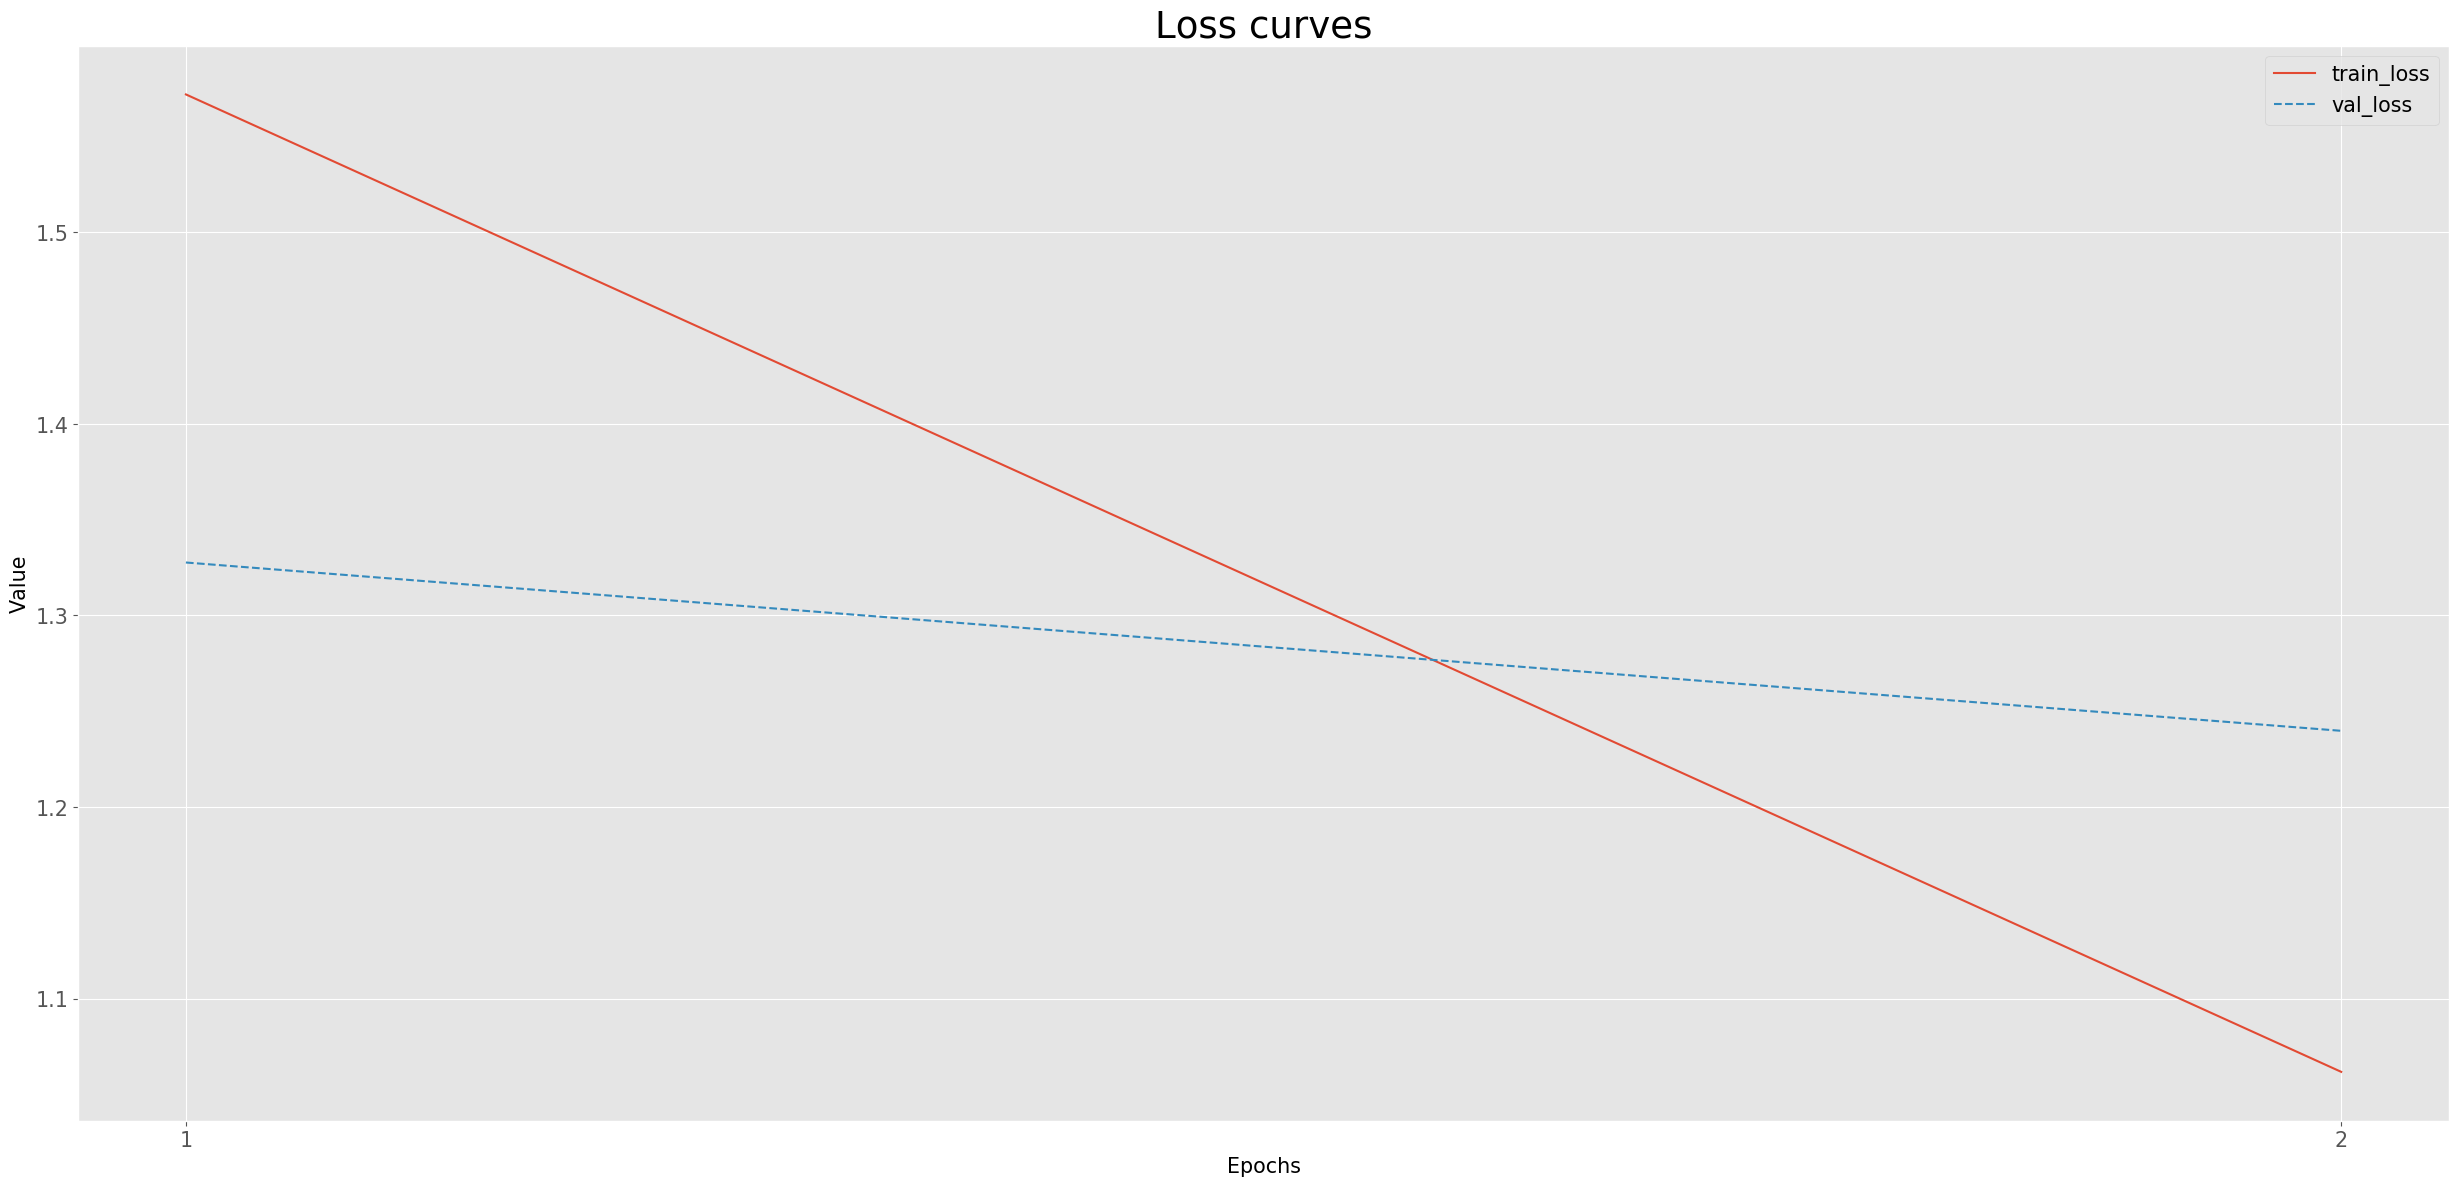

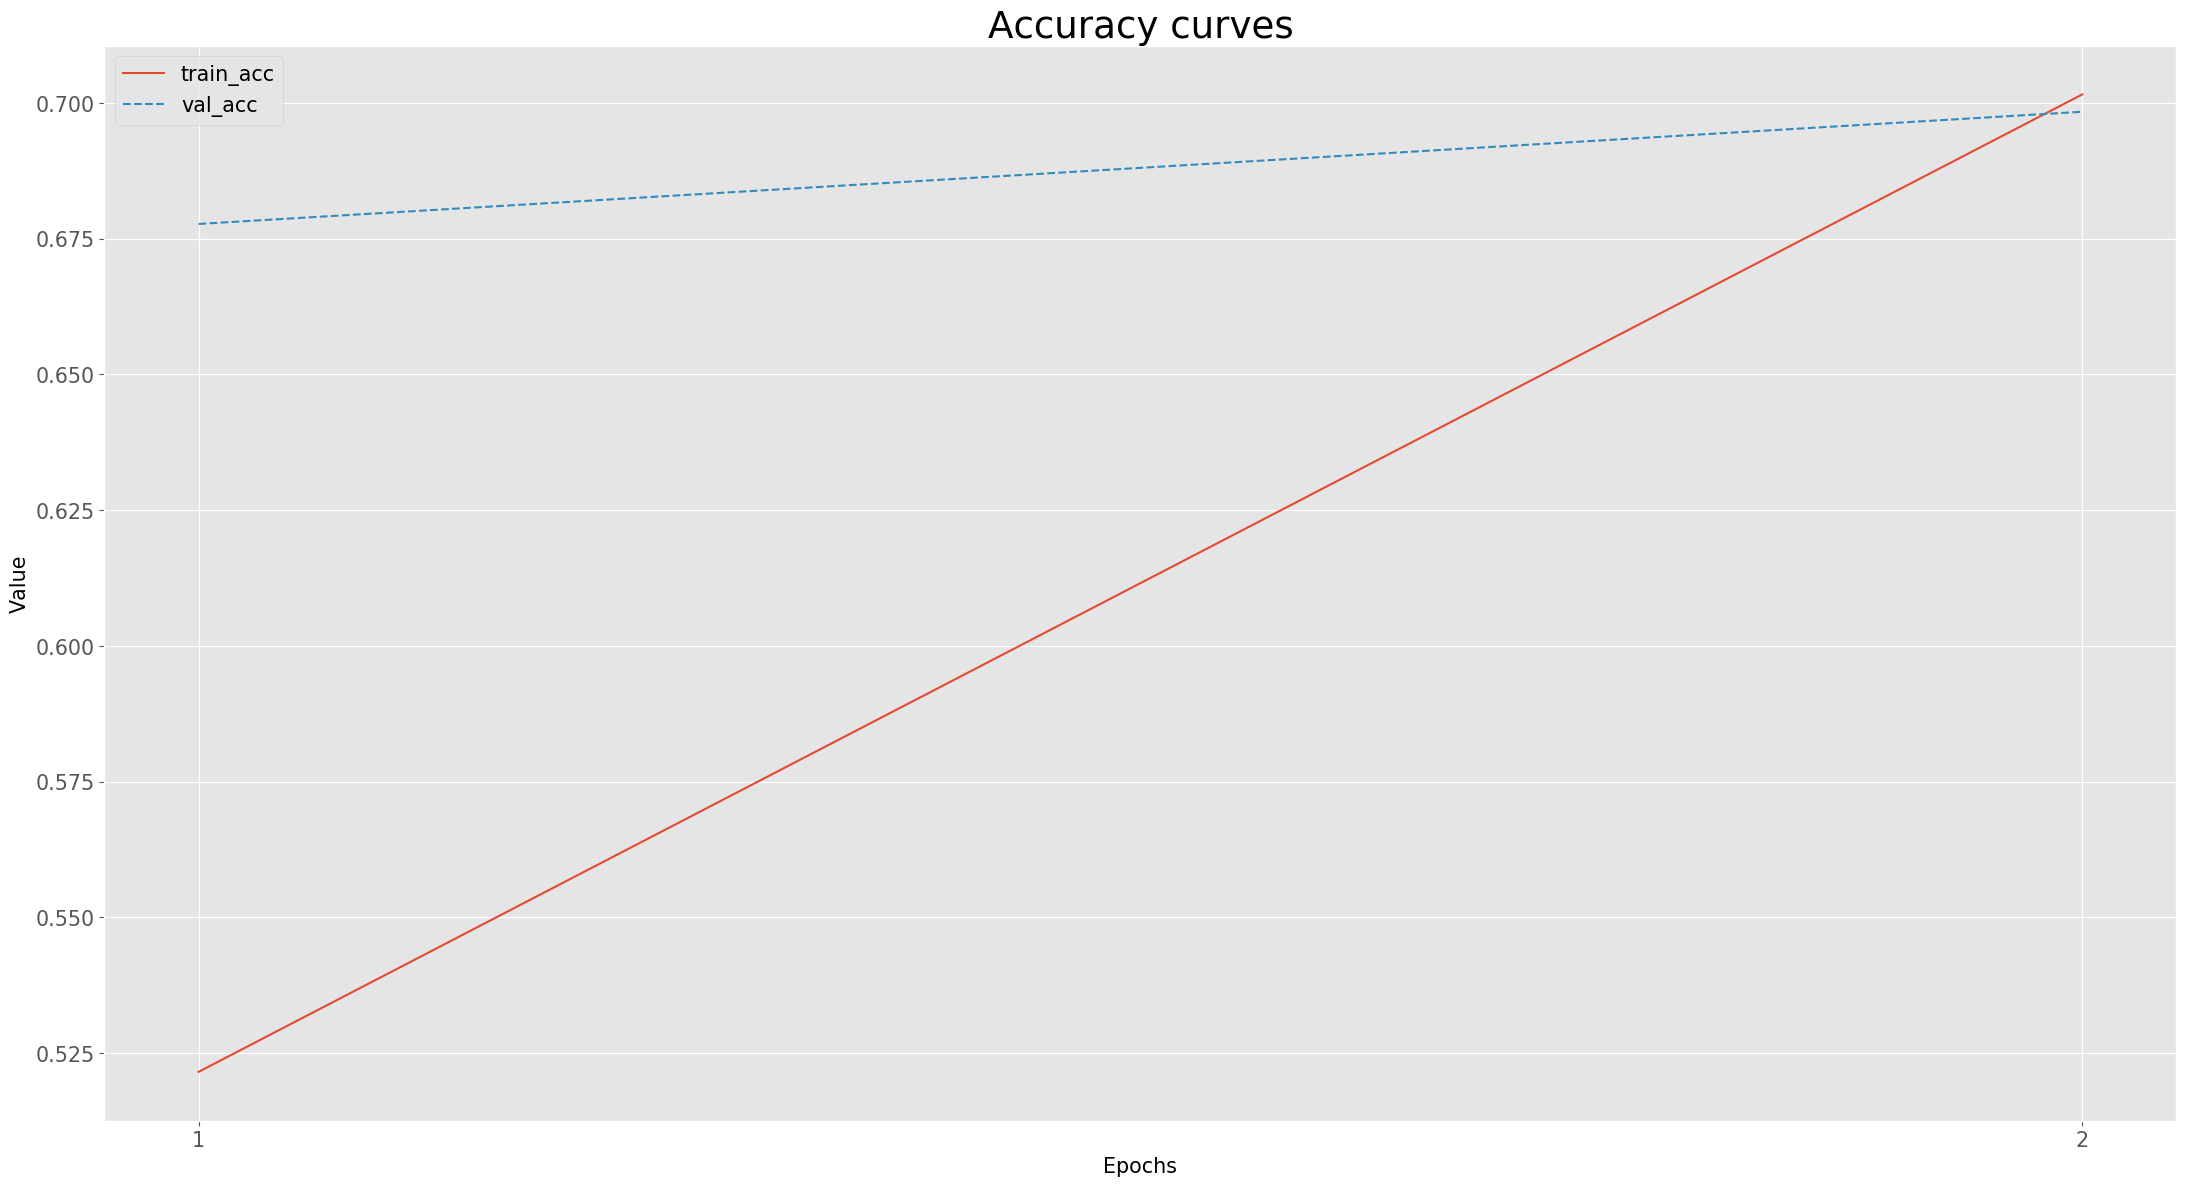

In [19]:
plot_dict(all_loss, use_xlabel='Epochs', use_ylabel='Value', use_title='Loss curves', use_linestyles=['-', '--'], magnify=0.2)
plot_dict(all_acc, use_xlabel='Epochs', use_ylabel='Value', use_title='Accuracy curves', use_linestyles=['-', '--'], magnify=0.2)

  0%|          | 0/40 [00:00<?, ?it/s]

/Users/pranavdeepak/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pranavdeepak/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pranavdeepak/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                 precision    recall  f1-score   support

          india       0.88      0.83      0.85       263
       pakistan       0.00      0.00      0.00         9
           news       0.00      0.00      0.00        42
  international       0.56      0.84      0.67       178
  entertainment       0.63      0.78      0.70        41
          sport       0.88      1.00      0.94        36
        science       0.52      0.37      0.43        30
          china       0.00      0.00      0.00         2
learningenglish       0.00      0.00      0.00         2
         social       0.00      0.00      0.00         3
      southasia       0.00      0.00      0.00         7
       business       0.00      0.00      0.00         9
  institutional       0.00      0.00      0.00         2
     multimedia       0.00      0.00      0.00         1

       accuracy                           0.71       625
      macro avg       0.25      0.27      0.26       625
   weighted avg       0.65   

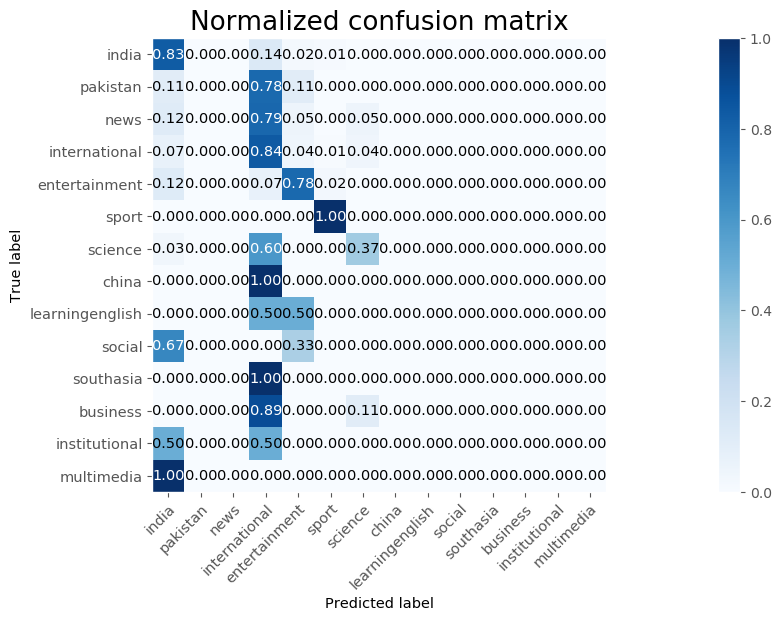

In [20]:
true_labels, predictions_labels, avg_epoch_loss = validation (test_dataloader, device)
evaluation_report = classification_report (true_labels, predictions_labels, labels=list(labels_ids.values()), target_names=list(labels_ids.keys()))
print(evaluation_report)
plot_confusion_matrix(y_true=true_labels, y_pred=predictions_labels, classes=list(labels_ids.keys()), normalize=True, magnify=0.1, use_title='Normalized confusion matrix');

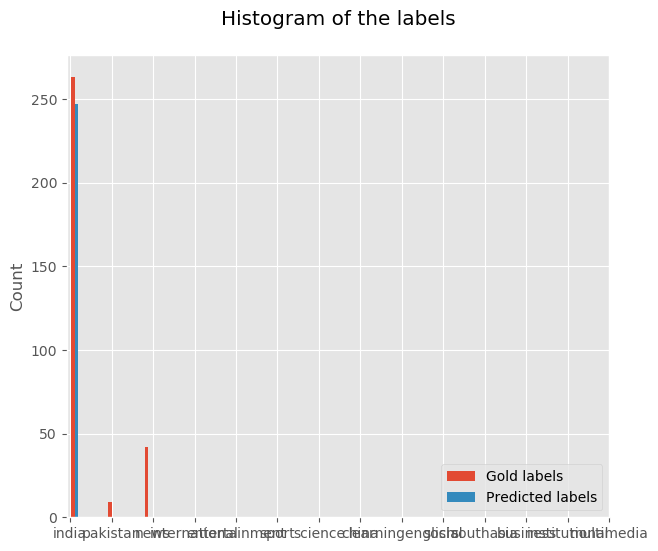

In [21]:
x = np.arange(n_labels)
bins = np.linspace(0, 2, 10)

fig, ax = plt.subplots(figsize=(7, 6))
plt.title('Histogram of the labels\n')
plt.hist([true_labels, predictions_labels], bins, label=['Gold labels', 'Predicted labels'] )
ax.set_ylabel('Count')
ax.set_xticks(x)
ax.set_xticklabels(list(labels_ids.keys()))
ax.legend(loc='lower right')
plt.show()

In [33]:
# Save the above model 
model.save_pretrained('./models/TC_LLM_model')

# Save the tokenizer
tokenizer.save_pretrained('./models/TC_LLM_tokenizer')

# Save the labels
import json
with open('./models/labels_ids.json', 'w') as fp:
    json.dump(labels_ids, fp)

# Save the model as a pickle file
import pickle
with open('./models/TC_LLM_model.pkl', 'wb') as fp:
    pickle.dump(model, fp)

# Save the tokenizer as a pickle file
with open('./models/TC_LLM_tokenizer.pkl', 'wb') as fp:
    pickle.dump(tokenizer, fp)

# Save the labels as a pickle file
with open('./models/labels_ids.pkl', 'wb') as fp:
    pickle.dump(labels_ids, fp)

In [34]:
# Load the model
import pickle
with open('./models/TC_LLM_model.pkl', 'rb') as fp:
    model = pickle.load(fp)

# Load the tokenizer
with open('./models/TC_LLM_tokenizer.pkl', 'rb') as fp:
    tokenizer = pickle.load(fp)

# Load the labels
import json
with open('./models/labels_ids.json') as json_file:
    labels_ids = json.load(json_file)

In [37]:
# Build a prediction function which takes the sentence , model and tokenizer as input and returns the predicted label
def predict (sentence, model, tokenizer, labels_ids, device, max_length=312):
    encoding = tokenizer.encode_plus (sentence,
                                        max_length=max_length,
                                        truncation=True,
                                        padding='max_length',
                                        add_special_tokens=True,
                                        return_tensors='pt',
                                        return_attention_mask=True,
                                        return_token_type_ids=False)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    outputs = model(input_ids, attention_mask)
    logits = outputs.logits
    logits = logits.detach().cpu().numpy()
    predict_content = logits.argmax(axis=-1).flatten().tolist()
    predict_label = list(labels_ids.keys())[list(labels_ids.values()).index(predict_content[0])]
    return predict_label

In [32]:
def text_classification(text):
    encoding = tokenizer.encode_plus(text, return_tensors='pt', max_length=max_length, truncation=True)
    output = model(encoding['input_ids'].to(device), encoding['attention_mask'].to(device))
    scores = output[0][0].detach().cpu().numpy()
    y_pred = np.argmax(scores)
    print("Text input: ", text)
    print("Prediction label:", y_pred)
    print("Prediction probabilities:", scores)
    print("Predicted label:", convert_id_to_label(y_pred))

def convert_label_to_id(label):
    return labels_ids[label]

def convert_id_to_label(id):
    return list(labels_ids.keys())[list(labels_ids.values()).index(id)]

text = "पिछले तीन दशकों के दौरान चीन में 40 करोड़ लोगों को गरीबी से निकाला गया है, और कुछ लोगों को तो बहुत फायदा हुआ है. लेकिन इससे असमानता भी बहुत बढ़ी है.चीन के सबसे गरीब प्रांत कुईचोऊ के एक गांव में रहने वाले 70 वर्षीय लु चिखुआन इस असमानता को यूं बचान करते हैं, ""मैंने टीवी पर देखा है कि अमीर कैसे अच्छे घरों में रहते हैं और फैंसी कारें चलाते हैं. मैं भी ऐसी जिंदगी का सपना देखता हूं, लेकिन मैं जानता हूं कि मैं तो बस सब्जियां उगा सकता हूं और गाय व सूअर पाल सकता हूं.""चीन और खास कर उसके तटीय शहरों में आर्थिक वृद्धि और उसकी चमकदमक लू से बहुत दूर है.लु ता ई भी उन दस करोड़ चीनी ग्रामीणों में हैं जो गरीबी रेखा के नीचे जिंदगी बसर कर रहे हैं. गांव में रह कर ही वो जैसे जैसे अपनी गुजर बसर कर रहे हैं.वो कहते हैं, ""मैंने शहर देखे हैं, वहां लोगों को रोजाना फैंसी रेस्त्राओं में खाना खाते देखा है. वे लोग अमीर है. मेरी जिंदगी का उनसे कोई मुकाबला ही नहीं है.""चीन की आर्थिक वृद्धि का फायदा सब लोगों को नहीं पहुंचा है. इस समस्या से चीन से नए नेतृत्व को निपटना है. गरीब और अमीर लोगों के बीच फासला लगातार बढ़ रहा है.ग्राणीण इलाकों से निकल कर राजधानी बीजिंग में जाएं तो वो एक अलग ही देश नजर आता है. वहां महंगे डिजाइनर बुटीक हैं जो चीन के नए शहरी धनाढ्यों को लुभाते हैं.चीन में करोड़पतियों की तादात लाखों में है. कुछ लोग तो बहुत ही अमीर हैं. वो दुनिया के सबसे अमीर लोगों की फेहरिस्त में आते हैं. वो इतने महंगे कपड़े पहनते हैं कि गांव में रह कर लु ता ई पूरी जिंदगी में भी इतना नहीं कमा पाएंगे.कुओ फेई चीन की एक मशहूर फैशन डिजाइनर हैं, वो कहती हैं, ""अब हम अमीर हैं तो वो सब करना चाहते हैं तो फैशनेबल है और अमीरी की पहचान है. ये स्वाभाविक बात है.""चिया चियाओ और छाओ फेंगफांग भी बीजिंग में रहते हैं और एक रीयल एस्टेट कंपनी में काम करते हैं. इन लोगों का संबंध मध्यम वर्ग है लेकिन वो खुद को अमीर नहीं मानते हैं. वो लगातार महंगे होते बीजिंग में एक फ्लैट नहीं खरीद सकते हैं.उनका कहना है, ""हां, हमारी जिंदगी गरीबों से बेहतर है, लेकिन हम अमीर लोगों से बहुत पीछे हैं. बहुत अच्छा तो नहीं है. हम तो बस बीच में फंसे हैं.""गरीब लोग भी खुद को ग्रामीण इलाकों में फंसा पाते हैं. चीन में संपन्नता के साथ साथ असमानता बढ़ रही है. इसलिए कम्युनिस्ट शासक इससे निपटने को अपनी अहम चुनौतियों में से एक मानते हैं.उन्हें डर है अगर ऐसा नहीं कर पाए तो उनकी खुद की पार्टी की वैधता पर ही सवाल उठेंगे."
text_classification(text)

Text input:  पिछले तीन दशकों के दौरान चीन में 40 करोड़ लोगों को गरीबी से निकाला गया है, और कुछ लोगों को तो बहुत फायदा हुआ है. लेकिन इससे असमानता भी बहुत बढ़ी है.चीन के सबसे गरीब प्रांत कुईचोऊ के एक गांव में रहने वाले 70 वर्षीय लु चिखुआन इस असमानता को यूं बचान करते हैं, मैंने टीवी पर देखा है कि अमीर कैसे अच्छे घरों में रहते हैं और फैंसी कारें चलाते हैं. मैं भी ऐसी जिंदगी का सपना देखता हूं, लेकिन मैं जानता हूं कि मैं तो बस सब्जियां उगा सकता हूं और गाय व सूअर पाल सकता हूं.चीन और खास कर उसके तटीय शहरों में आर्थिक वृद्धि और उसकी चमकदमक लू से बहुत दूर है.लु ता ई भी उन दस करोड़ चीनी ग्रामीणों में हैं जो गरीबी रेखा के नीचे जिंदगी बसर कर रहे हैं. गांव में रह कर ही वो जैसे जैसे अपनी गुजर बसर कर रहे हैं.वो कहते हैं, मैंने शहर देखे हैं, वहां लोगों को रोजाना फैंसी रेस्त्राओं में खाना खाते देखा है. वे लोग अमीर है. मेरी जिंदगी का उनसे कोई मुकाबला ही नहीं है.चीन की आर्थिक वृद्धि का फायदा सब लोगों को नहीं पहुंचा है. इस समस्या से चीन से नए नेतृत्व को निपटना है. गरीब और अमीर लोगों के बीच फासला लगातार बढ़

In [38]:
predict(text, model, tokenizer, labels_ids, device, max_length=312)

'international'